In [1]:
# Notebook initialization
% matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.use('nbagg') # To display interactive figures
import sys
sys.path.append('/media/margot/DATA/Margot/ownCloud/CODE/Python_code')

In [2]:
# Imports
from utils.simulations import *
import matplotlib.pyplot as plt
from data_analysis.extracell_funcs_NEW import loadTexStim
import glob
import numpy as np
from miscellaneous.convertVideo import playMovieFromMat
import matlab.engine
from utils.volterra_kernels import lsq_kernel, movie_to_BWT
from utils.theano_rf_models import fit_volterra_theano

In [3]:
# Parameters
stim_size=9
stim_dir='/media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218'
n_stim=200
power_law=1
stim_fracs={'train':0.7,'reg':0.1,'val':0.2}
colors='rgbycm'
line_width=2
numEpochs=30
epochSize=50
noise_ampl=1
noise_law='poisson'
subunit_ampl=0.06
computed_rfs=['volt1','BWT']
compute_modes=['linsolve','theano']

<IPython.core.display.Javascript object>


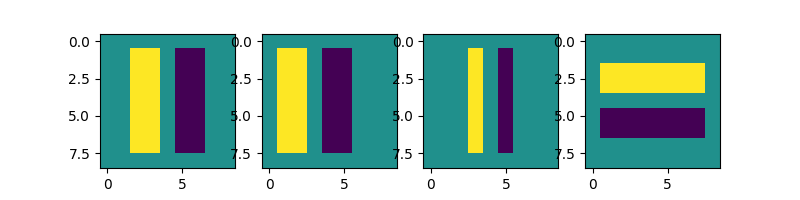

In [4]:
# Generate subunits
subunits=[onoffSubunit(stim_size,updw_margin=1,side_margin=2,phase=0,transpose=False),
          onoffSubunit(stim_size,updw_margin=1,side_margin=2,phase=1,transpose=False),
          onoffSubunit(stim_size,updw_margin=1,side_margin=3,phase=0,transpose=False),
          onoffSubunit(stim_size,updw_margin=1,side_margin=2,phase=0,transpose=True)]

subunits=np.concatenate(subunits,axis=1)
subunits=(subunits-subunits.mean(axis=0))*1./subunits.std(axis=0)*subunit_ampl
plt.figure(figsize=(2*subunits.shape[1],2))
for isub in range(subunits.shape[1]):
    plt.subplot(1,subunits.shape[1],isub+1)
    plt.imshow(subunits[:,isub].reshape(stim_size,stim_size))

In [5]:
# Define models
model_funcs={'linear1': lambda stim_mat: np.dot(stim_mat,subunits[:,0:1]),
             'LN1': lambda stim_mat: LNLmodel_resp(stim_mat,subunits[:,0:1],subunits_exp=power_law,output_exp=power_law),
             'LN2': lambda stim_mat: LNLmodel_resp(stim_mat,subunits[:,1:2],subunits_exp=power_law,output_exp=power_law),
             #'LN3': lambda stim_mat: LNLmodel_resp(stim_mat,subunits[:,2:3],subunits_exp=power_law,output_exp=power_law),
             #'LN4': lambda stim_mat: LNLmodel_resp(stim_mat,subunits[:,3:4],subunits_exp=power_law,output_exp=power_law),
             'LNLN1': lambda stim_mat: LNLmodel_resp(stim_mat,subunits,subunits_exp=power_law,output_exp=power_law,subunits_weights=0.25), 
             'LNLN2': lambda stim_mat: LNLmodel_resp(stim_mat,subunits,subunits_exp=power_law,output_exp=power_law,subunits_weights=[0.25,-0.25,0.25,-0.25]),
             'LNLN3': lambda stim_mat: LNLmodel_resp(stim_mat,subunits,subunits_exp=power_law,output_exp=power_law,subunits_weights=[0.25,0.25,-0.25,-0.25]),
             'LNLN4': lambda stim_mat: LNLmodel_resp(stim_mat,subunits,subunits_exp=power_law,output_exp=power_law,subunits_weights=[-0.125,-0.3,0.45,0.05])}
model_names=sorted(model_funcs.keys())

Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0001.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0002.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0003.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0004.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0005.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0006.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0007.tex
Loading /media/margot/DATA/Margot/ownCloud/STIMULI/tex_stimuli/mixedstims_tex_20pix_std60_090218/mixedtypes_fr20_0008.tex
Loading /media/margot/DA

<IPython.core.display.Javascript object>


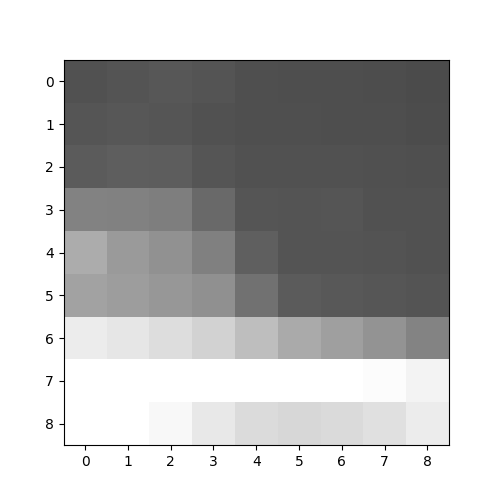

In [6]:
# Load stimulus
stim_list=sorted(glob.glob(stim_dir+'/*.tex'))[:n_stim]
stim=loadTexStim(stim_list,crop_range=np.array([[0,stim_size],[0,stim_size]]))
stim=np.concatenate(stim,axis=0)
stim=(stim-stim.mean())*1./stim.std()
print stim.shape
playMovieFromMat(stim)
stim=stim.reshape(stim.shape[0],-1)

<IPython.core.display.Javascript object>


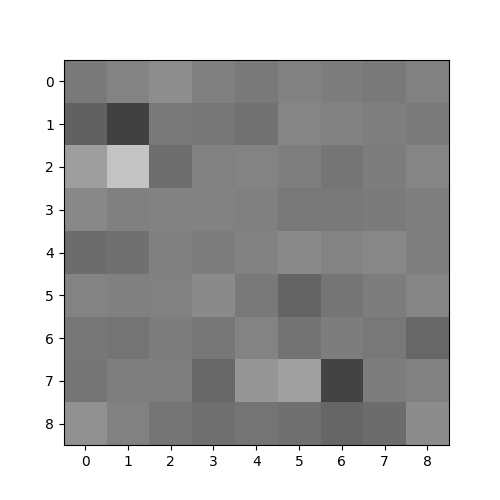

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7fab91613b90>)

In [7]:
# Compute stim BWT
#if not(vars().has_key('matlab_engine')):
#    matlab_engine=matlab.engine.start_matlab()
#stim_BWT=movie_to_BWT(stim.reshape(-1,stim_size,stim_size), matlab_engine=matlab_engine)
stim_BWT=movie_to_BWT(stim)
playMovieFromMat(stim_BWT.reshape(-1,stim_size,stim_size))

In [8]:
# Set stim subparts (training, regularization, validation)
stim_frac_names=stim_fracs.keys()
data_indices={key: np.arange(int(np.floor(stim.shape[0]*stim_fracs[key]))) for key in stim_frac_names}
for ifrac in range(1,len(stim_frac_names)):
    data_indices[stim_frac_names[ifrac]]+=data_indices[stim_frac_names[ifrac-1]][-1]+1

<IPython.core.display.Javascript object>


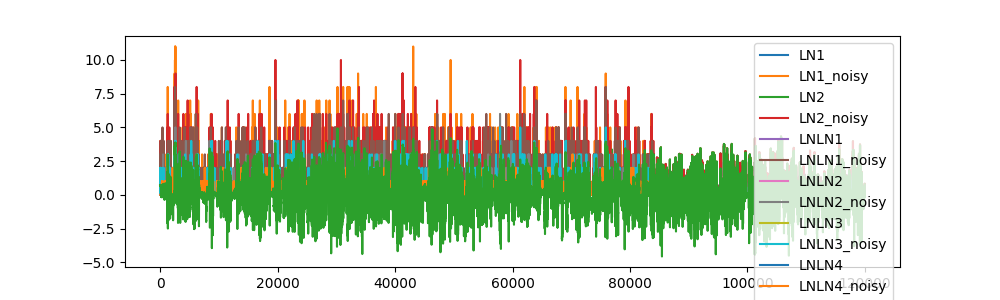

In [9]:
# Compute responses
resps={model: model_funcs[model](stim) for model in model_names}
for model in model_names: # add_noise
    if ((noise_law=='normal') and (noise_ampl>0)) or np.all(resps[model]>=0):
        resps[model+'_noisy']=resps[model].copy()
        if noise_law=='normal':
            resps[model+'_noisy'][data_indices['train']]+=np.random.normal(size=resps[model][data_indices['train']].shape,scale=resps[model][data_indices['train']].std()*noise_ampl)
        elif noise_law=='poisson':
            resps[model+'_noisy'][data_indices['train']]=np.random.poisson(resps[model][data_indices['train']])
model_names=sorted(resps.keys())
plt.figure(figsize=(10,3));
for model in model_names:
    plt.plot(resps[model])
plt.legend(model_names)        

model='LNLN2'
np.corrcoef(resps[model+'_noisy'][data_indices['train']].flatten(),resps[model][data_indices['train']].flatten())[0,1]
#resps[model+'_noisy'][data_indices['train']]

del kernels
model='LN1'
rf='volt1'
cm='theano'
kernels,rfs[model][rf][cm]['terr'],rfs[model][rf][cm]['verr'],rfs[model][rf][cm]['tcorr'],rfs[model][rf][cm]['vcorr']=fit_volterra_theano(stim[data_indices['train']],resps[model][data_indices['train']],stim[data_indices['reg']],resps[model][data_indices['reg']],orders=['0','1'],numEpochs=numEpochs,epochSize=epochSize)
print resps[model][data_indices['train']][:10].T
print kernels['1'][:10].T
rfs[model][rf][cm].update(kernels)
print rfs['LN1']['volt1']['theano']['1'][:10].T

del kernels
model='LN2'
kernels,rfs[model][rf][cm]['terr'],rfs[model][rf][cm]['verr'],rfs[model][rf][cm]['tcorr'],rfs[model][rf][cm]['vcorr']=fit_volterra_theano(stim[data_indices['train']],resps[model][data_indices['train']],stim[data_indices['reg']],resps[model][data_indices['reg']],orders=['0','1'],numEpochs=numEpochs,epochSize=epochSize)
print resps[model][data_indices['train']][:10].T
print kernels['1'][:10].T
rfs[model][rf][cm].update(kernels)
print rfs['LN1']['volt1']['theano']['1'][:10].T
print rfs['LN2']['volt1']['theano']['1'][:10].T

In [10]:
import utils.theano_rf_models
reload(utils.theano_rf_models)
from utils.theano_rf_models import fit_volterra_theano

# Compute rfs
rfs={model:{} for model in model_names}

for model in model_names:
    rfs[model]={rf: {cm: {} for cm in compute_modes} for rf in computed_rfs}
    for rf in computed_rfs:
        for cm in compute_modes:
            if (rf=='volt1') and (cm=='linsolve'):
                rfs[model][rf][cm].update(lsq_kernel(stim[data_indices['train']],resps[model][data_indices['train']],orders=['0','1']))
            elif (rf=='volt1') and (cm=='theano'):
                kernels,rfs[model][rf][cm]['terr'],rfs[model][rf][cm]['verr'],rfs[model][rf][cm]['tcorr'],rfs[model][rf][cm]['vcorr']=fit_volterra_theano(stim[data_indices['train']],resps[model][data_indices['train']],stim[data_indices['reg']],resps[model][data_indices['reg']],orders=['0','1'],numEpochs=numEpochs,epochSize=epochSize)
                rfs[model][rf][cm].update(kernels)
            elif (rf=='BWT') and (cm=='linsolve'):  
                rfs[model][rf][cm].update(lsq_kernel(stim_BWT[data_indices['train']],resps[model][data_indices['train']],orders=['0','1on','1off']))
            elif (rf=='BWT') and (cm=='theano'):      
                kernels,rfs[model][rf][cm]['terr'],rfs[model][rf][cm]['verr'],rfs[model][rf][cm]['tcorr'],rfs[model][rf][cm]['vcorr']=fit_volterra_theano(stim_BWT[data_indices['train']],resps[model][data_indices['train']],stim_BWT[data_indices['reg']],resps[model][data_indices['reg']],orders=['0','1on','1off'],numEpochs=numEpochs,epochSize=epochSize)
                rfs[model][rf][cm].update(kernels)

Starting fitting
Finished epoch:  0 train error:  43.70957310996265 val error:  42.88421513106905 train corr: 0.01456626893007417 val corr: -0.007053634064628373
Finished epoch:  1 train error:  8.857518757937235 val error:  8.411517466933459 train corr: 0.1285289455360793 val corr: 0.11447516132877594
Finished epoch:  2 train error:  2.630487667853676 val error:  2.458253458169095 train corr: 0.251664840474469 val corr: 0.2149284932210095
Finished epoch:  3 train error:  0.8257702667585374 val error:  0.7801175043363215 train corr: 0.41999816366704906 val corr: 0.40008085212470856
Finished epoch:  4 train error:  0.24377433520744246 val error:  0.23460023692399345 train corr: 0.6695267593575979 val corr: 0.6244913708228828
Finished epoch:  5 train error:  0.13668298831995912 val error:  0.12015529872432999 train corr: 0.7769064441454329 val corr: 0.7494435868504609
Finished epoch:  6 train error:  0.10507917692764639 val error:  0.09259644784649729 train corr: 0.828202726585779 val co

In [11]:
print np.all(rfs['LN1']['volt1']['theano']['1']==rfs['LN2']['volt1']['theano']['1'])
print np.corrcoef(rfs['LN1']['volt1']['theano']['1'].flatten(),rfs['LN2']['volt1']['theano']['1'].flatten())[0,1]

False
0.5926600349614998


<IPython.core.display.Javascript object>


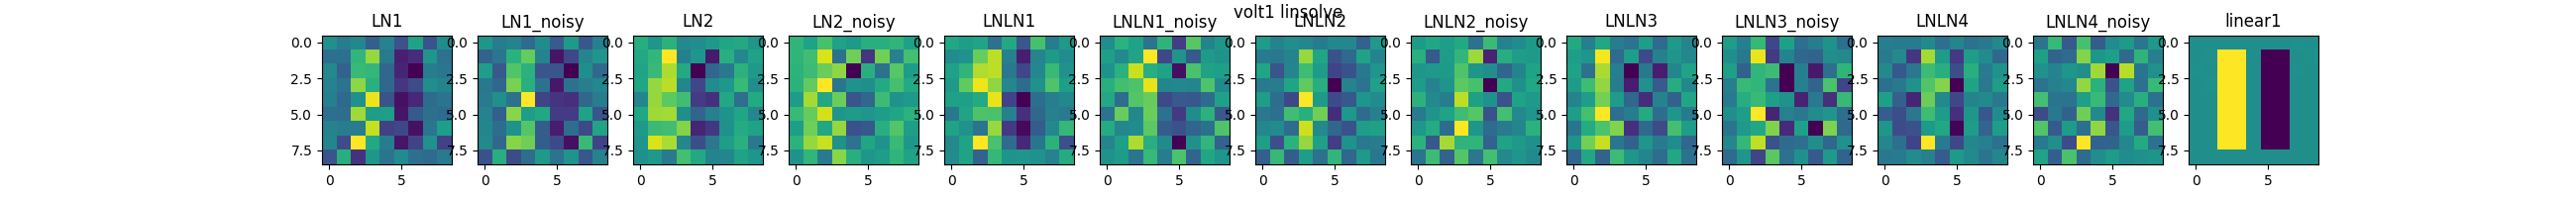

<IPython.core.display.Javascript object>


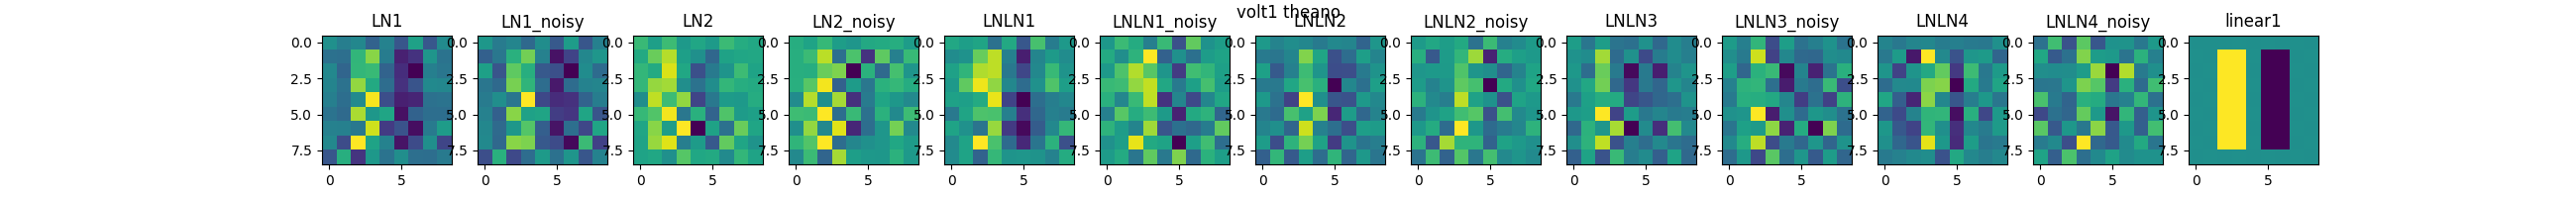

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


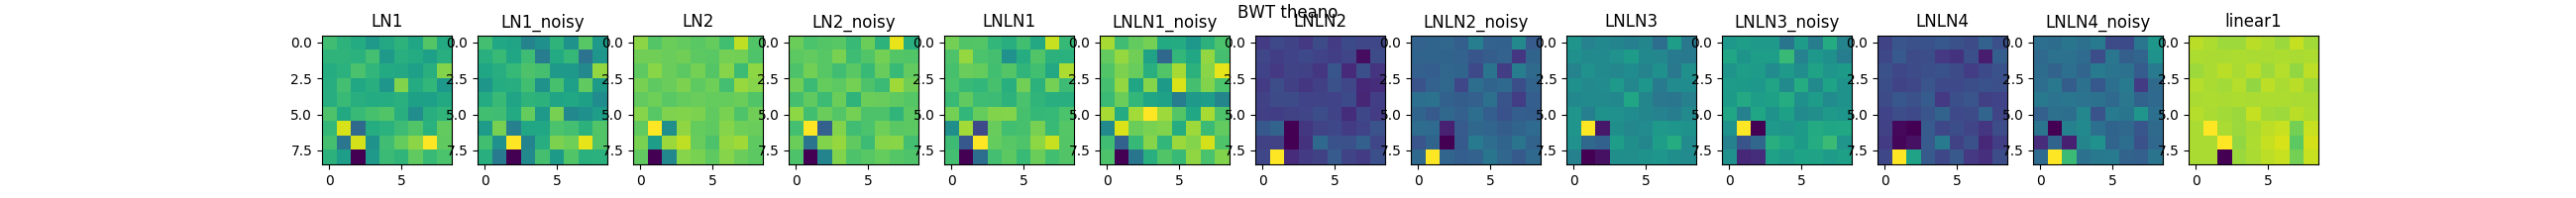

In [12]:
# Display rfs
for rf in computed_rfs:
    for cm in compute_modes:
        plt.figure(figsize=(2*len(model_names),2))
        plt.suptitle(rf+' '+cm)
        for imod in range(len(model_names)):
            plt.subplot(1,len(model_names),imod+1)
            plt.imshow(rfs[model_names[imod]][rf][cm]['1on' if rf=='BWT' else '1'].reshape(stim_size,stim_size))
            plt.title(model_names[imod])

In [13]:
# Compute predictions and correlations
rf_preds={model:{} for model in model_names}
rf_corr={model:{} for model in model_names}
for model in model_names:
    rf_preds[model]={rf: {} for rf in computed_rfs}
    rf_corr[model]={rf: {cm: {} for cm in compute_modes} for rf in computed_rfs}
    for rf in computed_rfs:
        for cm in compute_modes:
            if rf=='volt1':
                rf_preds[model][rf][cm]=rfs[model][rf][cm]['0']+np.dot(stim,rfs[model][rf][cm]['1'])
            elif rf=='BWT':    
                rf_preds[model][rf][cm]=rfs[model][rf][cm]['0']+np.dot(np.maximum(stim_BWT,0),rfs[model][rf][cm]['1on'])+np.dot(np.maximum(-stim_BWT,0),rfs[model][rf][cm]['1off'])
            for frac in  stim_fracs:  
                rf_corr[model][rf][cm][frac]=np.corrcoef(rf_preds[model][rf][cm][data_indices[frac]].flatten(),resps[model][data_indices[frac]].flatten())[0,1]

<IPython.core.display.Javascript object>


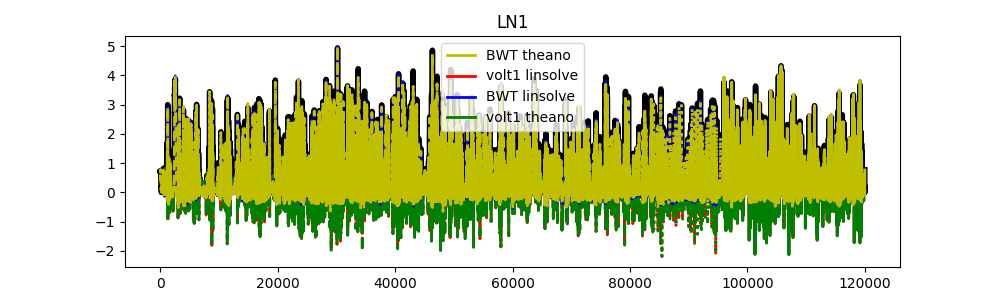

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


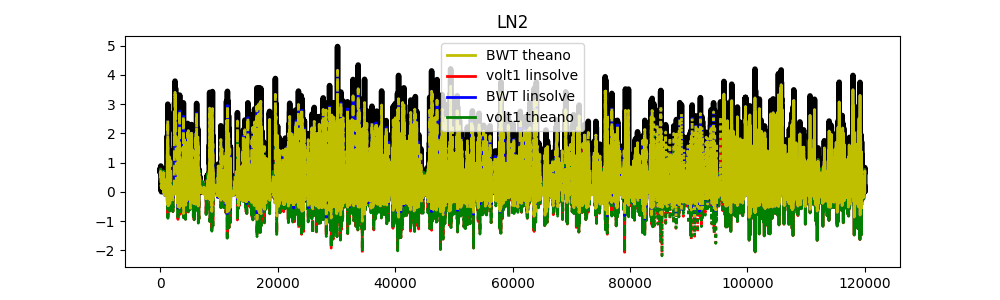

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


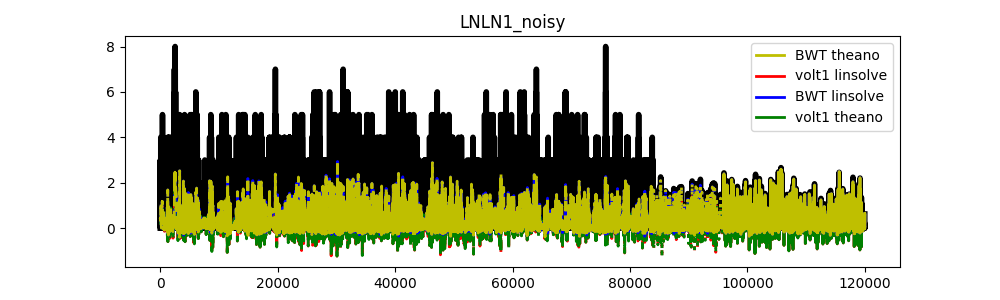

<IPython.core.display.Javascript object>


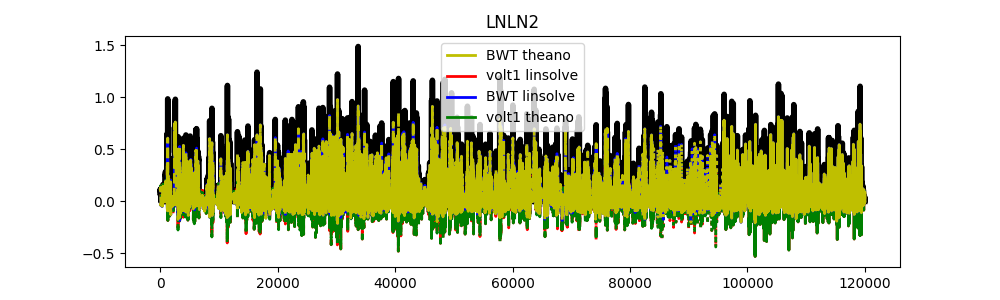

<IPython.core.display.Javascript object>


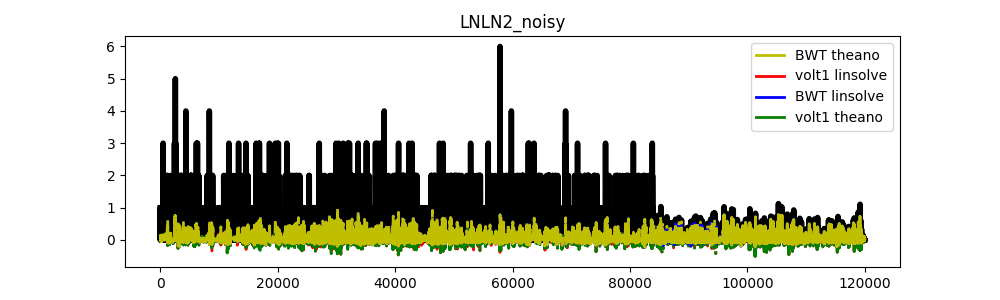

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


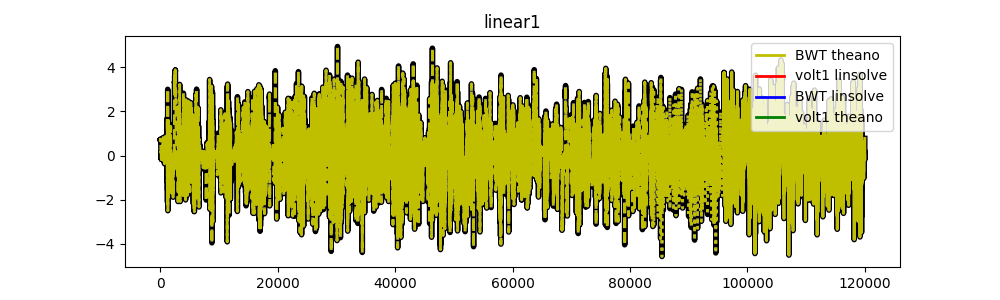

In [14]:
# Plot predictions
for model in model_names:
    plt.figure(figsize=(10,3))
    plt.plot(resps[model],'k',linewidth=line_width*2)
    count=0
    leg_handles={}
    for rf in computed_rfs:
        for cm in compute_modes:
            plt.plot(data_indices['train'],rf_preds[model][rf][cm][data_indices['train']],colors[count]+'--',linewidth=line_width)
            plt.plot(data_indices['reg'],rf_preds[model][rf][cm][data_indices['reg']],colors[count]+':',linewidth=line_width)
            leg_handles[rf+' '+cm]=plt.plot(data_indices['val'],rf_preds[model][rf][cm][data_indices['val']],colors[count],linewidth=line_width)[0]
            count+=1
    plt.legend(leg_handles.values(),leg_handles.keys()) 
    plt.title(model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


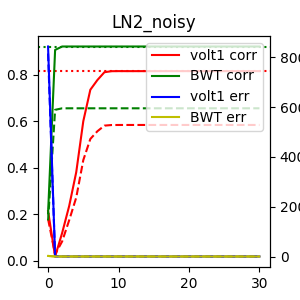

<IPython.core.display.Javascript object>


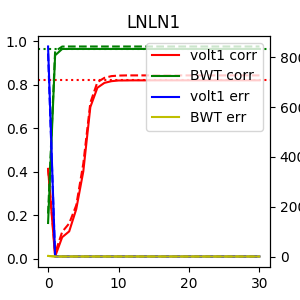

<IPython.core.display.Javascript object>


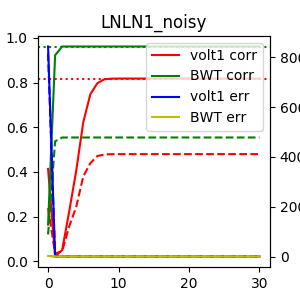

<IPython.core.display.Javascript object>


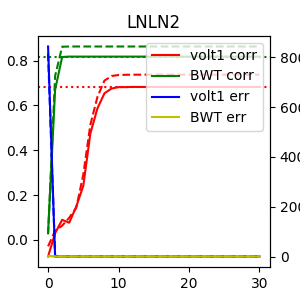

<IPython.core.display.Javascript object>


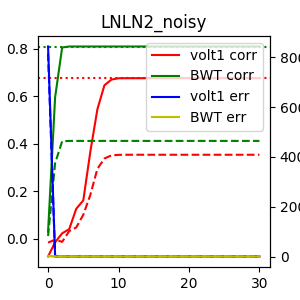

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


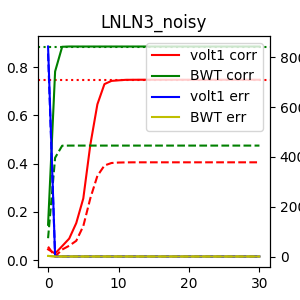

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


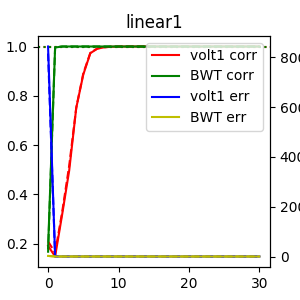

In [15]:
# Display correlation across fit
for imod in range(len(model_names)):
    plt.figure(figsize=(3,3))
    count=0
    leg_items=[]
    for rf in computed_rfs: 
        plt.axhline(rf_corr[model_names[imod]][rf]['linsolve']['reg'],color=colors[count],linestyle=':')
        plt.plot(rfs[model_names[imod]][rf]['theano']['tcorr'],colors[count]+'--')
        leg_items.append(plt.plot(rfs[model_names[imod]][rf]['theano']['vcorr'],colors[count])[0])
        count+=1
    plt.twinx()
    for rf in computed_rfs: 
        plt.plot(rfs[model_names[imod]][rf]['theano']['terr'],colors[count]+'--')
        leg_items.append(plt.plot(rfs[model_names[imod]][rf]['theano']['verr'],colors[count])[0])
        count+=1
    plt.title(model_names[imod])
    plt.legend(leg_items,[rf+' corr' for rf in computed_rfs]+[rf+' err' for rf in computed_rfs])